## Fine-tuning LLMs
https://towardsdatascience.com/fine-tuning-large-language-models-llms-23473d763b91

In [1]:
# fine tuning
%pip install evaluate
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np

Note: you may need to restart the kernel to use updated packages.
'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/ccugutrillague/mambaforge/envs/coderefinery/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [2]:
# base model
model_checkpoint = 'distilbert-base-uncased'

# define label maps
id2label = {0: "Source", 1: "Container", 2: "packagemanager"}
label2id = {"Source":0, "`Container`":1, "Packagemanager":2}


# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=3, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
id2label

{0: 'Source', 1: 'Container', 2: 'packagemanager'}

In [4]:
# load dataset
dataset = load_dataset("carlosug/ResearchInstall")
dataset
dataset = dataset.filter(
    lambda x: (x["content"] != None)
)
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/39 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['software', 'repo_name', 'readme_url', 'content', 'plan', 'steps', 'optional_steps', 'extra_info_optional'],
        num_rows: 29
    })
})

In [5]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

,software,repo_name,readme_url,content,plan,steps,optional_steps,extra_info_optional
0,ensuring-trustworthy-and-ethical-behaviour-in,https://paperwithcode.com/paper/,https://raw.githubusercontent.com/AAAI-DISIM-U...,## Installation\n\n**OS X & Linux:**\n1. To d...,"binary, source",[plan binary]>>step1. follow the instructions ...,**Windows:**\n1. To download and install SICS...,You will see different windows opening:\nProlo...
1,only-the-curve-shape-matters-training,https://paperwithcode.com/paper/,https://raw.githubusercontent.com/cfeng783/GTT...,## Getting Started\n\n#### Install dependencie...,source,[plan source]>> [INCOMPLETE] step1. Install de...,None,None
2,aydiv-adaptable-yielding-3d-object-detection,https://paperwithcode.com/paper/,https://raw.githubusercontent.com/sanjay-810/A...,### **Installation**\n1. Prepare for the runn...,"source,docker",[plan source]>> step1. Prepare for the running...,None,None
3,cartesian-atomic-cluster-expansion-for,https://paperwithcode.com/paper/,https://raw.githubusercontent.com/BingqingChen...,## Installation\n\nPlease refer to the `setup....,source,[plan source]>>[INCOMPLETE] step1. please refe...,None,None
4,teller-a-trustworthy-framework-for,https://paperwithcode.com/paper/,https://raw.githubusercontent.com/less-and-les...,## Getting Started\n\nStep 1: Download the dat...,binary,[plan binary]>> step1: Download the dataset fo...,None,None
5,continuous-time-radar-inertial-and-lidar,https://paperwithcode.com/paper/,https://raw.githubusercontent.com/utiasASRL/st...,## Installation\n\nClone this repository and i...,source,[plan source]>> step1. clone this repository a...,None,None
6,robust-parameter-fitting-to-realistic-network,https://paperwithcode.com/paper/,https://raw.githubusercontent.com/PFischbeck/p...,"# Installation\n\n- Make sure you have Python,...",source,[plan source]>> step1. Make sure you have Pyth...,step7. Optional: Download the file `output-dat...,None
7,get-tok-a-genai-enriched-multimodal-tiktok,https://paperwithcode.com/paper/,https://raw.githubusercontent.com/gabbypinto/G...,## Installation\npip install -r requirements.t...,packagemanager,[plan packagemanager]>>step1. pip install -r r...,None,*Note: I did not us a virtual environment so t...
8,geometric-slosh-free-tracking-for-robotic,https://paperwithcode.com/paper/,https://raw.githubusercontent.com/jonarriza96/...,## Installation\n\n### Dependencies\n\nInitial...,source,[plan source]>> step1. Check dependencies. ste...,None,None
9,real-time-line-based-room-segmentation-and,https://paperwithcode.com/paper/,https://raw.githubusercontent.com/EricssonRese...,## Installation\nThe project can be installed ...,source,[plan source]>>[INCOMPLETE]step1. Run the comm...,None,None


In [6]:
dataset = dataset["train"].train_test_split(train_size=0.8, seed=3)
dataset["validation"] = dataset.pop("test")
dataset["test"] = dataset["train"]
dataset

DatasetDict({
    train: Dataset({
        features: ['software', 'repo_name', 'readme_url', 'content', 'plan', 'steps', 'optional_steps', 'extra_info_optional'],
        num_rows: 23
    })
    validation: Dataset({
        features: ['software', 'repo_name', 'readme_url', 'content', 'plan', 'steps', 'optional_steps', 'extra_info_optional'],
        num_rows: 6
    })
    test: Dataset({
        features: ['software', 'repo_name', 'readme_url', 'content', 'plan', 'steps', 'optional_steps', 'extra_info_optional'],
        num_rows: 23
    })
})

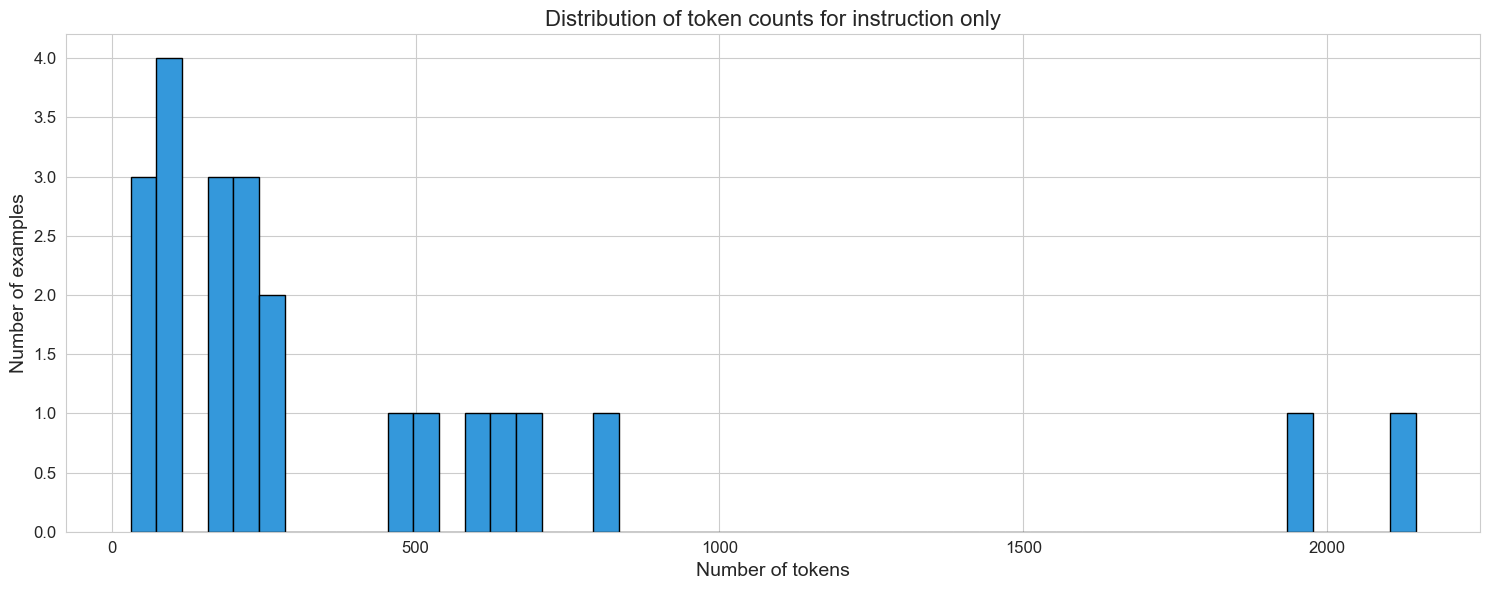

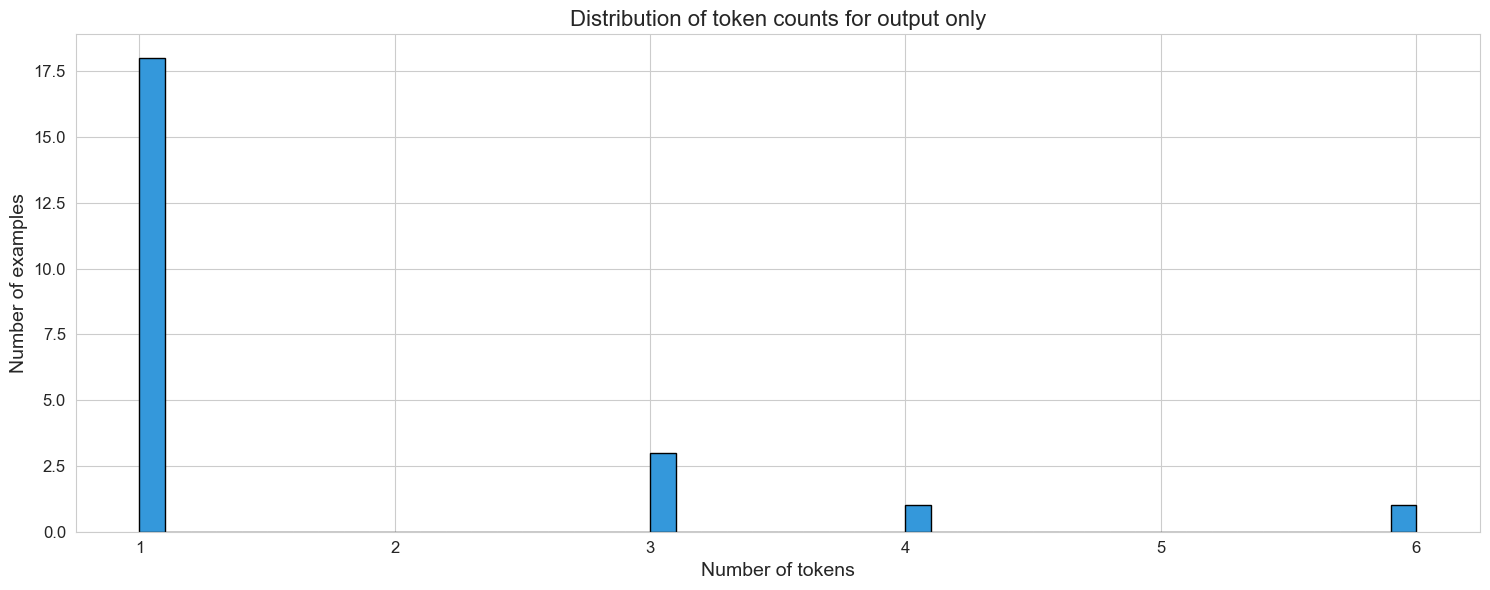

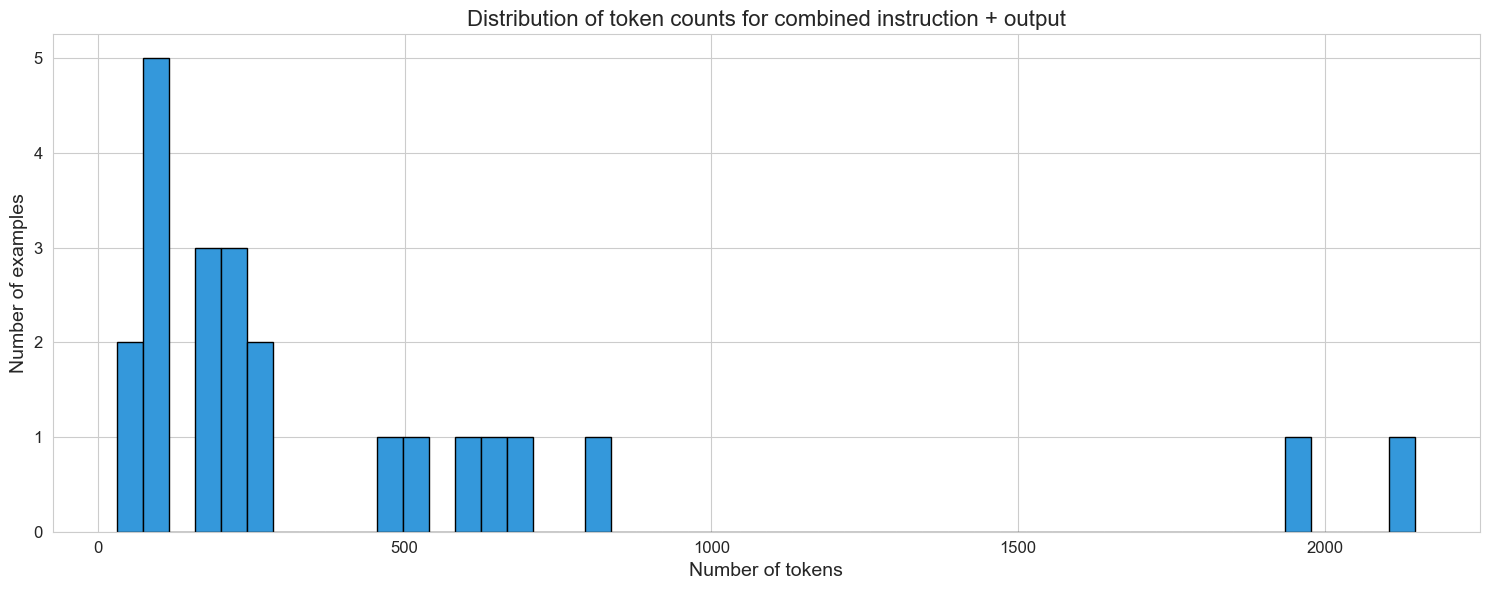

In [7]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["content"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["plan"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [8]:
# preproces data
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

In [9]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["content"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['software', 'repo_name', 'readme_url', 'content', 'plan', 'steps', 'optional_steps', 'extra_info_optional', 'input_ids', 'attention_mask'],
        num_rows: 23
    })
    validation: Dataset({
        features: ['software', 'repo_name', 'readme_url', 'content', 'plan', 'steps', 'optional_steps', 'extra_info_optional', 'input_ids', 'attention_mask'],
        num_rows: 6
    })
    test: Dataset({
        features: ['software', 'repo_name', 'readme_url', 'content', 'plan', 'steps', 'optional_steps', 'extra_info_optional', 'input_ids', 'attention_mask'],
        num_rows: 23
    })
})

In [10]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, 
                                          references=labels)}

In [12]:
# define list of examples
text_list = ["conda install.", "you should download.", 
"first step is to clone the repo.", "```python3 install requirements.txt```.", 
"docker run ."]

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " + id2label[predictions.tolist()])

Untrained model predictions:
----------------------------
conda install. - Source
you should download. - Source
first step is to clone the repo. - Source
```python3 install requirements.txt```. - Source
docker run . - Source


In [13]:
# fine tuning with lora
peft_config = LoraConfig(task_type="SEQ_CLS", # sequence classification
                        r=4, # intrinsic rank of trainable weight matrix
                        lora_alpha=32, # this is like a learning rate
                        lora_dropout=0.01, # probablity of dropout
                        target_modules = ['q_lin']) # we apply lora to query layer only

In [14]:
# train model
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,222,662 || all params: 67,585,542 || trainable%: 1.8090585113603144


In [15]:
# define hyperparameters for model training
# hyperparameters
lr = 1e-3 # size of optimization step 
batch_size = 4 # number of examples processed per optimziation step
num_epochs = 10 # number of times model runs through training data

# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [17]:
# creater trainer object
trainer = Trainer(
    model=model, # our peft model
    args=training_args, # hyperparameters
    train_dataset=tokenized_dataset["train"], # training data
    eval_dataset=tokenized_dataset["validation"], # validation data
    tokenizer=tokenizer, # define tokenizer
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics, # evaluates model using compute_metrics() function from before
)

# train model
trainer.train()

  0%|          | 0/60 [00:00<?, ?it/s]

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.

In [ ]:
%ls

corpus_generator.ipynb
data/
distilbert-base-uncased-lora-text-classification/
explore_instructions.ipynb
extractINSTALL.py
mapper.py
results/


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
trainer.save_model("results/ft-model")

In [ ]:
from transformers import pipeline
from transformers import AutoModelForTokenClassification
from transformers import AutoTokenizer
from transformers import TokenClassificationPipeline
import torch


In [ ]:
EXAMPLE = "where are you?"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("karlholten/distilbert-carpentries-restaurant-ner")

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("karlholten/distilbert-carpentries-restaurant-ner")

In [ ]:
nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="first")

In [ ]:
ner_results = nlp(EXAMPLE)

In [ ]:
print(ner_results)

[]
